# ldpred2_simulations
Synthetic data generation for LDPred2 analysis using the SIMU library with known underlying heritability, etc.

In [27]:
import pandas as pd
import numpy as np

bfile = '/home/oleksanf/github/comorment/magma/reference/magma/g1000_eur/g1000_eur'
df=pd.read_csv(f'{bfile}.bim', header=None, names='CHR SNP GP BP A1 A2'.split(), sep='\t')
df=df[df['CHR'].isin([21, 22])].copy()
hm3=pd.read_csv('/home/oleksanf/github/comorment/containers/reference/hapmap3/w_hm3.justrs', header=None, names=['SNP'])
df_hm3 = pd.merge(df, hm3)

# random 80% subset of hm3 plust 2000 randomly selected SNPs
# one of these will be used as a genotype panel
# the other subset will be used for GWAS summary statistics
for i in [1, 2]:
    pd.concat([df_hm3.sample(int(len(df_hm3) * 0.8)), df.sample(2000) ]).drop_duplicates().sort_values(['CHR', 'BP'])[['SNP']].to_csv(f'hm3_rand_v{i}.justrs', index=False, header=None, sep='\t')


In [32]:
import os
for i in [1, 2]:
    os.system(f'plink --bfile {bfile} --extract hm3_rand_v{i}.justrs --make-bed --out g1000_eur_chr21to22_hm3rnd{i}')

PLINK v1.90b6.9 64-bit (4 Mar 2019)            www.cog-genomics.org/plink/1.9/
(C) 2005-2019 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to g1000_eur_chr21to22_hm3rnd1.log.
Options in effect:
  --bfile /home/oleksanf/github/comorment/magma/reference/magma/g1000_eur/g1000_eur
  --extract hm3_rand_v1.justrs
  --make-bed
  --out g1000_eur_chr21to22_hm3rnd1

128694 MB RAM detected; reserving 64347 MB for main workspace.
22665064 variants loaded from .bim file.
503 people (240 males, 263 females) loaded from .fam.
--extract: 29882 variants remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 503 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
29882 variants and 503 people pass filters and QC.
Note: No phenotypes pre

In [61]:
os.system('simu_linux --bfile g1000_eur_chr21to22_hm3rnd1 --qt --causal-n 50 --hsq 0.7')
os.system('plink2 --glm --bfile g1000_eur_chr21to22_hm3rnd2 --pheno simu.pheno --out simu')

*********************************************************************
* SIMU - library for simulation of GWAS summary statistics
* Version v0.9.4
* (C) 2018 Oleksandr Frei
* Norwegian Centre for Mental Disorders Research / University of Oslo
* GNU General Public License v3
*********************************************************************
Call:
simu_linux \
	--bfile g1000_eur_chr21to22_hm3rnd1 \
	--qt \
	--causal-n 50 \
	--hsq 0.7 

Analysis started: 2022-Dec-09 11:13:10
Opening g1000_eur_chr21to22_hm3rnd1... done, 503 samples, 29882 variants.
Options in effect (after applying default setting to non-specified parameters):
	--bfile g1000_eur_chr21to22_hm3rnd1 \
	--qt \
	--num-traits 1 \
	--hsq 0.7 \
	--num-components 1 \
	--causal-n 50 \
	--trait1-sigsq 1 \
	--out simu \
	--seed 1670584390218420 \

Calculate allele frequencies (for causal markers only)... 
Generate effect sizes from normal distribution...
Calculate phenotypes... 
Save phenotypes to simu.pheno...
Save causal variants 

0

Text(0.5, 1.0, 'manhattan')

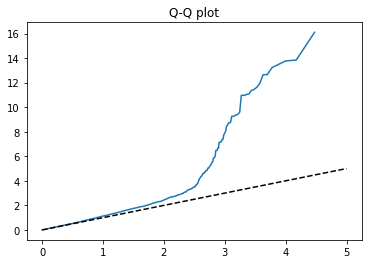

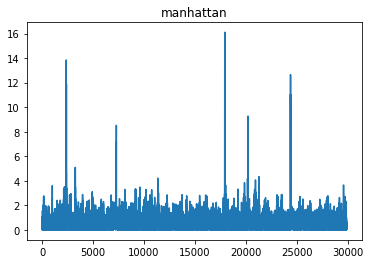

In [62]:
import pandas as pd
import numpy as np
for trait in ['1']:
    df=pd.read_csv(f'simu.trait{trait}.glm.linear', delim_whitespace=True)
    df['A2'] = df['REF']; idx=df['A2']==df['A1']; df.loc[idx, 'A2']=df.loc[idx, 'ALT']; del df['REF']; del df['ALT']; del df['TEST']
    df.dropna(inplace=True)
    df.rename(columns={'ID':'SNP', '#CHROM':'CHR', 'POS':'BP', 'OBS_CT':'N', 'T_STAT':'Z', 'A1_FREQ':'FRQ'}, inplace=True)
    df[sorted(df.columns)].to_csv(f'trait{trait}.sumstats.gz', sep='\t', index=False)

import matplotlib.pyplot as plt
plt.plot(-np.log10(np.array(range(1,1+len(df)))/len(df)),    
        -np.log10(sorted(df['P'].values)))
plt.plot([0, 5], [0, 5], 'k--')
plt.title('Q-Q plot')

plt.figure()
plt.plot(-np.log10(df['P'].values))
plt.title('manhattan')

In [23]:
import os
os.system("""    
export RSCRIPT="singularity exec --bind $COMORMENT/ldpred2_ref:/ldpred2_ref --home=$PWD:/home $SIF/r.sif Rscript"
export fileGeno="g1000_eur_chr21to22_hm3rnd1.bed"
export fileGenoRDS="g1000_eur_chr21to22_hm3rnd1.rds"
export fileSumstats=trait1.sumstats.gz
export filePheno=simu.pheno
export colPheno=trait1
export fileOut=ldpred2

$RSCRIPT ldpred2.R  --ldpred-mode inf --file-pheno $filePheno --col-pheno $colPheno $fileGenoRDS $fileSumstats $fileOut.inf
$RSCRIPT ldpred2.R  --ldpred-mode auto --file-pheno $filePheno --col-pheno $colPheno $fileGenoRDS $fileSumstats $fileOut.auto
"""
)

Loading backingfile: g1000_eur_chr21to22_hm3rnd1.rds 
Loading external phenotype in file simu.pheno 

### Reading LD reference meta-file from /ldpred2_ref/map_hm3_plus.rds

### Reading summary statistics trait1.sumstats.gz 
Loaded 29887 SNPs
Filtering SNPs based on --chr2use
Retained 29887 out of 29887 
Matching sumstats to genotypes


29,887 variants to be matched.
1 ambiguous SNPs have been removed.
22,428 variants have been matched; 0 were flipped and 21 were reversed.


Matching sumstats to LD reference


22,428 variants to be matched.
0 ambiguous SNPs have been removed.
19,602 variants have been matched; 0 were flipped and 13,837 were reversed.



### Loading LD reference from /ldpred2_ref/ldref_hm3_plus/LD_with_blocks_chr@.rds
21 : loading LD for 9785 out of 20582 SNPs
22 : loading LD for 9817 out of 21233 SNPs

### Running LD score regression
Results: Intercept = 0.9586156 H2 = 1.336648 

### Starting polygenic scoring
Running LDPRED2 infinitesimal model
Calculating beta inf
Scoring all individuals...Correlation with phenotype: 0.9165 

### Writing fam file with PGS and phenotype


19,602 variants to be matched.
0 ambiguous SNPs have been removed.
19,602 variants have been matched; 0 were flipped and 13,837 were reversed.


Loading backingfile: g1000_eur_chr21to22_hm3rnd1.rds 
Loading external phenotype in file simu.pheno 

### Reading LD reference meta-file from /ldpred2_ref/map_hm3_plus.rds

### Reading summary statistics trait1.sumstats.gz 
Loaded 29887 SNPs
Filtering SNPs based on --chr2use
Retained 29887 out of 29887 
Matching sumstats to genotypes


29,887 variants to be matched.
1 ambiguous SNPs have been removed.
22,428 variants have been matched; 0 were flipped and 21 were reversed.


Matching sumstats to LD reference


22,428 variants to be matched.
0 ambiguous SNPs have been removed.
19,602 variants have been matched; 0 were flipped and 13,837 were reversed.



### Loading LD reference from /ldpred2_ref/ldref_hm3_plus/LD_with_blocks_chr@.rds
21 : loading LD for 9785 out of 20582 SNPs
22 : loading LD for 9817 out of 21233 SNPs

### Running LD score regression
Results: Intercept = 0.9586156 H2 = 1.336648 

### Starting polygenic scoring
Running LDPRED2 auto model
Plotting diagnostics: ldpred2.auto.png


Saving 7 x 7 in image


Filtering chains
Scoring all individuals...Correlation with phenotype: 0.8667 

### Writing fam file with PGS and phenotype


19,602 variants to be matched.
0 ambiguous SNPs have been removed.
19,602 variants have been matched; 0 were flipped and 13,837 were reversed.


0

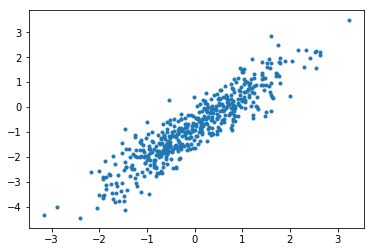

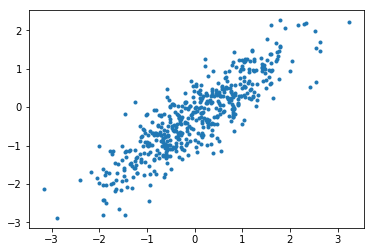

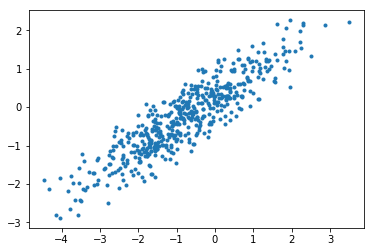

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
df_inf=pd.read_csv('ldpred2.inf', delim_whitespace=True)
df_auto=pd.read_csv('ldpred2.auto', delim_whitespace=True)
plt.figure()
plt.plot(df_inf['trait1'].values, df_inf['score'].values, '.')
plt.figure()
plt.plot(df_auto['trait1'].values, df_auto['score'].values, '.')
plt.figure()
plt.plot(df_inf['score'].values, df_auto['score'].values, '.')

In [14]:
import pandas as pd
import numpy as np
df=pd.read_csv('Height.inf', delim_whitespace=True)
print(df[['Height', 'score']].corr().values[0, 1])

df=pd.read_csv('Height.auto', delim_whitespace=True)
print(df[['Height', 'score']].corr().values[0, 1])


0.49163784315499853
0.49987836916644984
